## Data Importation

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('./Dataset/train.csv')
test = pd.read_csv('./Dataset/test.csv')


In [47]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [48]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [50]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [51]:
train["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [52]:
train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


from what we observe , the are almost 20% missing valuein the age , and 70% missing values in cabin and only 2 passengers have missing values for embarked feature

let's see infos 

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


there is 5 categorical features and 7 numerical features

## Data Analysis
let's make further exploration to our data 
### Sex 

Sex
female    74.203822
male      18.890815
Name: Survived, dtype: float64


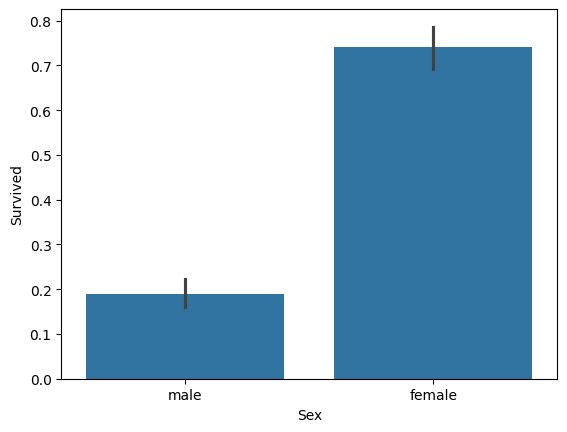

In [54]:
sns.barplot(x="Sex", y="Survived", data=train)
survived_sex = train.groupby('Sex')['Survived'].mean() * 100
print(survived_sex)


as we can see , females are more likely to survive : 18% of males survived while 74% of females survived 

### Pclass

Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64


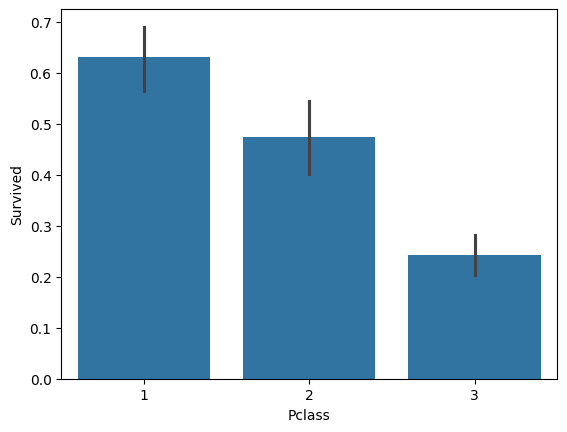

In [55]:
sns.barplot(x="Pclass", y="Survived", data=train)
survived_pclass = train.groupby('Pclass')['Survived'].mean() * 100
print(survived_pclass)

- 62% of class 1 survived 
- 47% of class 2 survived 
- 24% of class 3 survived

### SibSp

SibSp
0    34.539474
1    53.588517
2    46.428571
3    25.000000
4    16.666667
5     0.000000
8     0.000000
Name: Survived, dtype: float64


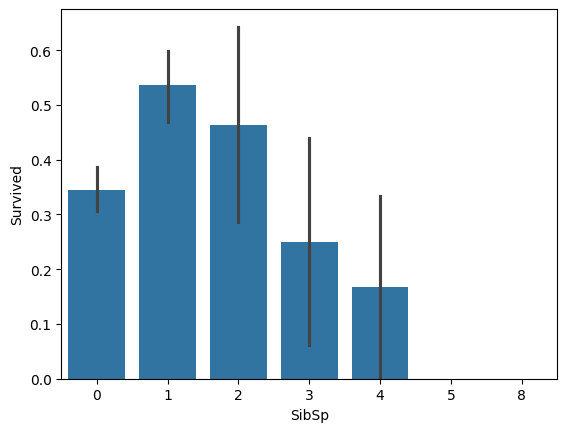

In [56]:
#draw a bar plot for SibSp vs. survival
sns.barplot(x="SibSp", y="Survived", data=train )
survived_sibsp = train.groupby('SibSp')['Survived'].mean() * 100
print(survived_sibsp)

- It's more likely to survive if you are traveling with 1 or 2 siblings/spouse than alone. 

### Parch

<Axes: xlabel='Parch', ylabel='Survived'>

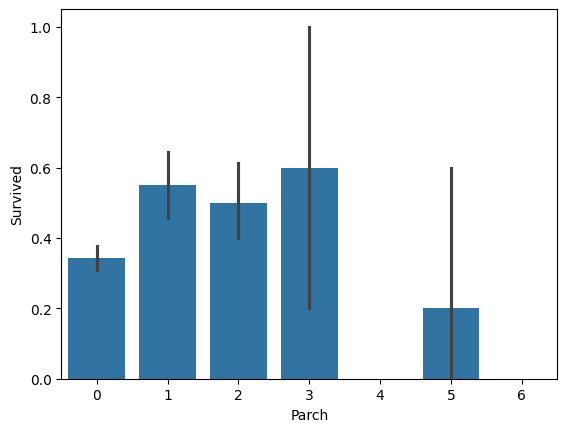

In [57]:
sns.barplot(x="Parch", y="Survived", data=train)


- people with less than 4 children or family members abroad are more likely to survive than those with 4 or more . 

### Age 

<Axes: xlabel='AgeGroup', ylabel='Survived'>

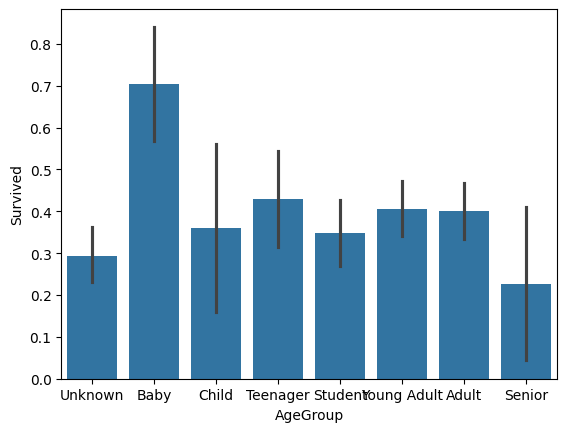

In [58]:
#sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)

#draw a bar plot of Age vs. survival
sns.barplot(x="AgeGroup", y="Survived", data=train)

- Babies are more likely to survive .

### Embarked

Embarked
C    168
Q     77
S    644
dtype: int64


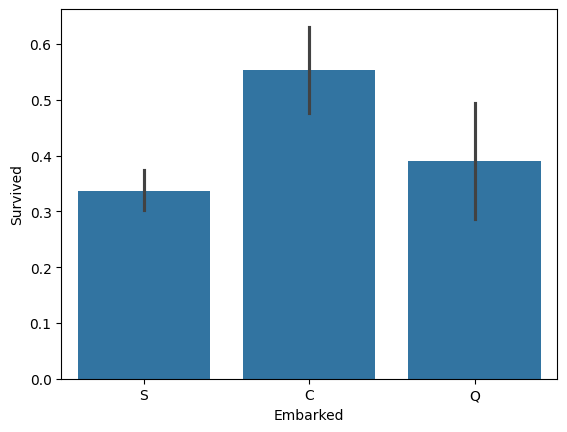

In [59]:
sns.barplot(x="Embarked",y="Survived", data=train)
survived_embarked = train.groupby("Embarked").size()
print(survived_embarked)

- we are remarking tha people embarking in C are more likely to survive
- Most of the passengers embarked from S , let's use that info to fill the missing values 

## Feature Engineering

Let's create some additional features from the existing ones ( feature engineering ) . let's drop the useless features ( ticket + cabin ) and add , family size

In [60]:
def feature_engineering (train, test):
    train['Family_Size']=train['SibSp']+train['Parch'] +1
    test['Family_Size']=test['SibSp']+test['Parch'] +1
    train = train.fillna({"Embarked": "S"})
train_df= train.copy()
test_df= test.copy()
feature_engineering(train_df,test_df)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Student,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult,1


In [62]:
combine=[train_df,test_df]
#extract a title for each Name in the train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train['Title'], train['Sex'])


KeyError: 'Title'

In [ ]:
age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

#I tried to get this code to work with using .map(), but couldn't.
#I've put down a less elegant, temporary solution for now.
train_df = train_df.fillna({"Age": train_df["Title"].map(age_title_mapping)})
test_df = test_df.fillna({"Age": test_df["Title"].map(age_title_mapping)})
train_df.head()

0        Student
1          Adult
2    Young Adult
3    Young Adult
4    Young Adult
Name: AgeGroup, dtype: category
Categories (8, object): ['Unknown' < 'Baby' < 'Child' < 'Teenager' < 'Student' < 'Young Adult' < 'Adult' < 'Senior']

In [ ]:
train_df["Title"].value_counts()

In [ ]:
corr_matrix = train_df.corr(numeric_only=True)

In [ ]:
corr_matrix["Survived"].sort_values(ascending=False)

As we can see , it seems that the Fare and Pclass are the most correlated attributes with the Survived attribute.

let's prepare our train set now

## Stratified Sampling



Now let's use Startified sampling from scikit learn , basically strata means spliting your dataset into many 

In [ ]:
from sklearn.model_selection import train_test_split
X= train_df.drop(['Survived'], axis=1)
y= train_df['Survived']
train_X, val_X ,train_y, val_y= train_test_split(X,y, test_size=0.2, stratify=train_df["Survived"], random_state=42)

## Pipeline Creation

let's create a pipline that prepares the data for training. but before let devise our dataset into numerical and categorical sub datasets

In [ ]:
num_features=["Age",'Fare',"SibSp","Parch","Level","Title"]
cat_features=['Sex',"Embarked","AgeGroup"]
ordinal_features=["AgeGroup"]

then to fix the problem of having some categories in the training set and others in the test set , we'll concatenate all of our data , and fit it 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler ,OneHotEncoder
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="most_frequent")),
 ('std_scaler', StandardScaler()),
 ])
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])
ordinal_pipeline = Pipeline([("ordinal_encoder", OrdinalEncoder()),("imputer", SimpleImputer(strategy="most_frequent"))    
])

In [ ]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([("num_pipeline", num_pipeline, num_features),("cat_pipeline", cat_pipeline, cat_features),("ordinal_pipeline", ordinal_pipeline, ordinal_features)])
train_prepared = full_pipeline.fit_transform(train_X)
test_prepared = full_pipeline.transform(test_df)
val_prepared = full_pipeline.transform(val_X)


## Selecting Best Model

there are many binary classification estimators , we want to choose the best one 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
classifiers = [LogisticRegression(),RandomForestClassifier(),KNeighborsClassifier(),SVC()]

let's evaluate the models without performing any hyperparameter tuning

In [ ]:
from numpy import mean
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score,precision_score
for classifier in classifiers:
    classifier.fit(train_prepared, train_y)
    pred= classifier.predict(val_prepared)
    print(classifier,"roc_auc",roc_auc_score(val_y, pred, average='weighted'))
    print(classifier,"accuracy",accuracy_score(val_y, pred))
    print(classifier,"precision",precision_score(val_y, pred))
    print(classifier,"recall",recall_score(val_y, pred))
    
    


From the previous results , we can say that the logistic regression is the best model to use 

## Hyperparameters Fine Tuning

first let's prepare the dataset for this 

In [ ]:
final_train_X = full_pipeline.fit_transform(X)
final_train_y = y

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Assuming final_train_X and final_train_y are your training data
rf_classifier = RandomForestClassifier()

param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'random_state': [42],  # Set a random state for reproducibility
}

rand_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=100, cv=5, scoring="accuracy", verbose=3, n_jobs=-1)
rand_search.fit(final_train_X, final_train_y)


In [ ]:
rand_search.best_params_

In [ ]:
rand_search.best_score_

In [ ]:
model = rand_search.best_estimator_

Now we will use the stratified kfold cross validation method to evaluate our model

In [ ]:
from sklearn.model_selection import StratifiedKFold
def stratified_cross_val(model, X, y, n_splits=20):
    accuracy=[]
    skf= StratifiedKFold(n_splits=n_splits)
    final_train_X = pd.DataFrame(X)
    skf.get_n_splits(final_train_X, y)
    for train_index, test_index in skf.split(X, y):
        train_X, val_X = X[train_index], X[test_index]
        train_y, val_y = y[train_index], y[test_index]
        model.fit(train_X, train_y)
        pred= model.predict(val_X)
        score = accuracy_score(val_y, pred)
        accuracy.append(score)
    return mean(accuracy)
        

from what we can see , the classifier performs better than the other models

In [ ]:
print(stratified_cross_val(model, final_train_X, final_train_y))

model.fit(train)

In [ ]:
model.fit(final_train_X, final_train_y)
predictions = model.predict(test_prepared)
predictions

let's now save the submission 

In [ ]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
output.head()

In [ ]:
output.tail()